# The Bernoulli Experiment


In [8]:
epochs = 2500 #Number of epochs for training
num_samples = 2500 #Number of samples (for plotting)
Ms = [1,2,3,5,10,30,50,100] #Number of Bernstein Coefs

In [9]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow.keras import initializers
from functools import partial

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import pandas as pd
from tqdm import tqdm


%load_ext autoreload
%autoreload 2
sns.set(style="whitegrid", font_scale=2.25)
# plt.rcParams.update({"text.usetex": True})
import sys

try: #If running in colab
    import google.colab
    IN_COLAB = True
    %tensorflow_version 2.x
    #!wget https://raw.githubusercontent.com/tensorchiefs/main/Python/Bernoulli/vimlts_fast.py
    #Manual upload since private repo
    sys.path.append(".")
    from vimlts_fast import VimltsLinear, ConjungateDenseViGauss
except:
    IN_COLAB = False
    sys.path.append('.')
    from vimlts_fast import VimltsLinear, ConjungateDenseViGauss

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


Likelihood: $$y \thicksim Bernoulli(\pi)$$

Prior: $$ \pi \thicksim  Beta(\alpha, \beta) $$

Posterior: $$p(\pi | y) = \frac{p(y| \pi) \cdot p(\pi)}{p(y)}$$

==> In this case the posterior is known because of the conjugate prior

==> Posterior is a Beta distribution too. Parameters:

$$p(\pi|y) \thicksim Beta(\alpha + \sum{x_i}, \beta+n-\sum{x_i})$$


Prior:
$p(\pi) \thicksim Beta(\alpha=0.5, \beta=5.)$

Text(0.5, 1.0, 'Prior p($\\pi$)')

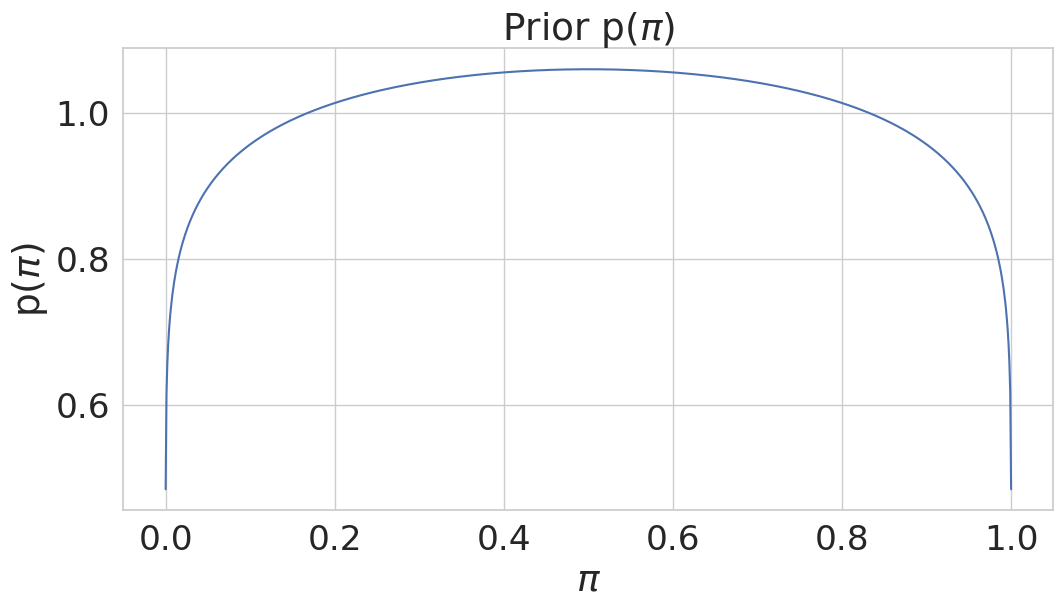

In [10]:
pis = np.linspace(0.0001, .9999, 1000)
alpha = 1.1
beta = 1.1
pdf_prior = stats.beta(a=alpha, b=beta).pdf(x=pis)
plt.figure(figsize=(12,6))
sns.lineplot(data=pd.DataFrame.from_dict({'p($\pi$)':pdf_prior, '$\pi$':pis}), x='$\pi$', y='p($\pi$)')
plt.title("Prior p($\pi$)")

Likelihood

In [11]:
data = np.ones((2))
ytensor = data.reshape(-1, 1)
ytensor

array([[1.],
       [1.]])

Text(0.5, 1.0, 'Likelihood p(y|$\\pi$)')

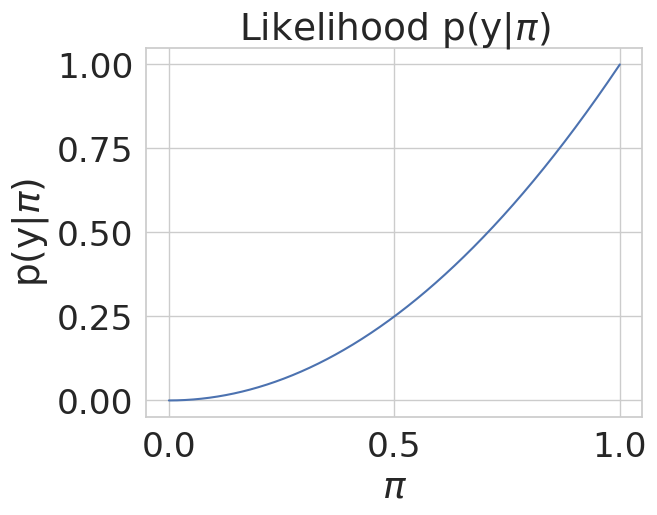

In [12]:
log_likelihood = [stats.bernoulli(p=pi).logpmf(data).sum() for pi in pis]
likelihood = np.exp(log_likelihood)
sns.lineplot(data=pd.DataFrame.from_dict({'p(y|$\pi$)':likelihood, '$\pi$':pis}), x='$\pi$', y='p(y|$\pi$)')
plt.title("Likelihood p(y|$\pi$)")

Posterior analytic

$$p(\pi|y) \thicksim Beta(\alpha + \sum{x_i}, \beta+n-\sum{x_i})$$

integral of pdf:  0.999786146673809


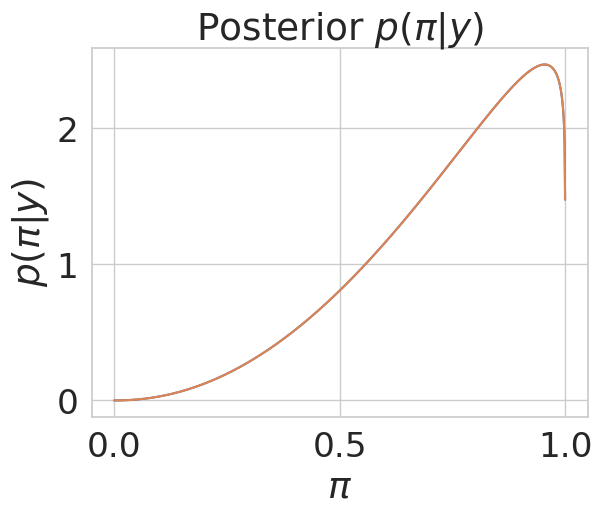

In [13]:
alpha_post = alpha + np.sum(data)
beta_post = beta + len(data) - np.sum(data)
pdf_post = stats.beta(a=alpha_post, b=beta_post).pdf(x=pis)
sns.lineplot(data=pd.DataFrame.from_dict({'$p(\pi|y)$':pdf_post, '$\pi$':pis}), x='$\pi$', y='$p(\pi|y)$')
plt.plot(pis, likelihood*pdf_prior/np.trapz(likelihood*pdf_prior, pis), linestyle='solid')
plt.title("Posterior $p(\pi|y)$")
print("integral of pdf: ", np.trapz(pdf_post, pis))

In [14]:
beta_post

1.1

like * prior same as analytic known posterior distribution

Now use VIMLTs to approximate posterior distribution


## TM-VI vs Gauss-VI


In [15]:
def scheduler(epoch, lr, lr_start, lr_stop, epochs):
    return lr_start + (lr_stop-lr_start)*(epoch/epochs)

@tf.function
def sample_bernoulli_nll(y_obs, y_pred):
    """
    Args:
        y_obs: true labels. Expected shape (#batch, 1) or (#batch)
        y_pred: model prediction. Expected shape (#samples, #batch, 1) or (#samples, #batch)

    Returns: sum of Nll
    """
    if len(y_pred.shape) == 2:  # Bug tf?! If we have a single output it squeezes y_pred. I did not want this behaviour.
        y_pred = y_pred[...,None]
    tf.debugging.check_numerics(y_pred, "Prediction for nll computation contains NaNs or Infs")
    error_str = f"Expected one of the above defined shapes. Got shapes: y_obs: {y_obs.shape}; y_pred: {y_pred.shape}"
    assert y_pred.shape[-1] == y_obs.shape[-1] or ((len(y_pred.shape) == 3) and y_pred.shape[-1] == 1), error_str

    dist = tfp.distributions.Bernoulli(probs=y_pred)
    nll_per_sample = -dist.log_prob(y_obs)
    nlls = tf.reduce_mean(nll_per_sample, axis=0)
    tf.debugging.check_numerics(nlls, "NLL contains NaNs or Infs")
    return tf.reduce_sum(nlls)
    # return 0.

def softplus_inv(y):
    return np.log(np.exp(y) - 1)

### initialize TM-VI

In [16]:
models = {}
for M in Ms:
    # init params
    kernel_initializers=dict(kernel_init_alpha_w = initializers.RandomNormal(mean=1.5),
                             kernel_init_beta_w = initializers.RandomNormal(),
                             kernel_init_alpha_z = initializers.RandomNormal(mean=1),
                             kernel_init_beta_z = initializers.RandomNormal(),
                             kernel_init_thetas = [initializers.RandomNormal(mean=-1.5, stddev=.3)] + [initializers.RandomNormal(mean=softplus_inv((2+1.5)/M), stddev=.5) for i in range(M)])
    # define model
    tf.random.set_seed(2)
    layer = VimltsLinear(1,
                         activation=tfp.bijectors.Sigmoid(low=1e-6, high=1.-1e-6),
                         **kernel_initializers,
                         num_samples=10000,
                         prior_dist=tfd.Beta(concentration1=alpha, concentration0=beta),
                         input_shape=(1,),)
    model = tf.keras.Sequential([layer], name=f"TM-VI-degree{M}")
    model.build(input_shape=(None, 1))
    models[f"TM-VI M={M}"] = model
model.summary()

Model: "TM-VI-degree100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vimlts_linear_7 (VimltsLin  (10000, None, 1)          105       
 ear)                                                            
                                                                 
Total params: 105 (420.00 Byte)
Trainable params: 105 (420.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### initialize VI Gauss implementation

In [17]:
tf.random.set_seed(2)
vi_gauss_l = ConjungateDenseViGauss(1,
                                   activation=tfp.bijectors.Sigmoid(low=1e-6, high=1.-1e-6),
                                   num_samples=num_samples,
                                   kernel_init_mu_w = initializers.Constant(0.),
                                   kernel_init_rhosigma_w = initializers.Constant(0.2),
                                   prior_dist=tfd.Beta(concentration1=alpha, concentration0=beta))
vi_gauss = tf.keras.Sequential([vi_gauss_l], name="Gauss-VI")
vi_gauss.build(input_shape=(None,1))
vi_gauss.summary()
models["Gauss-VI"] = vi_gauss

Model: "Gauss-VI"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conjungate_dense_vi_gauss   (2500, None, 1)           2         
 (ConjungateDenseViGauss)                                        
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
print(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print('Tensorflow version: ',tf.__version__, )
a = tf.convert_to_tensor(np.empty((1,1,3)))
b = tf.convert_to_tensor(np.empty((3,3)))

a @ b

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
Tensorflow version:  2.14.0


<tf.Tensor: shape=(1, 1, 3), dtype=float64, numpy=array([[[1.235164e-318, 4.940656e-322, 4.940656e-324]]])>

### show initial distribution

VI Gaus with: N(<tf.Variable 'conjungate_dense_vi_gauss/kernel_mu:0' shape=(1, 1) dtype=float32, numpy=array([[0.]], dtype=float32)>,[[0.79813886]])


Text(0.5, 1.0, 'Initial distribution')

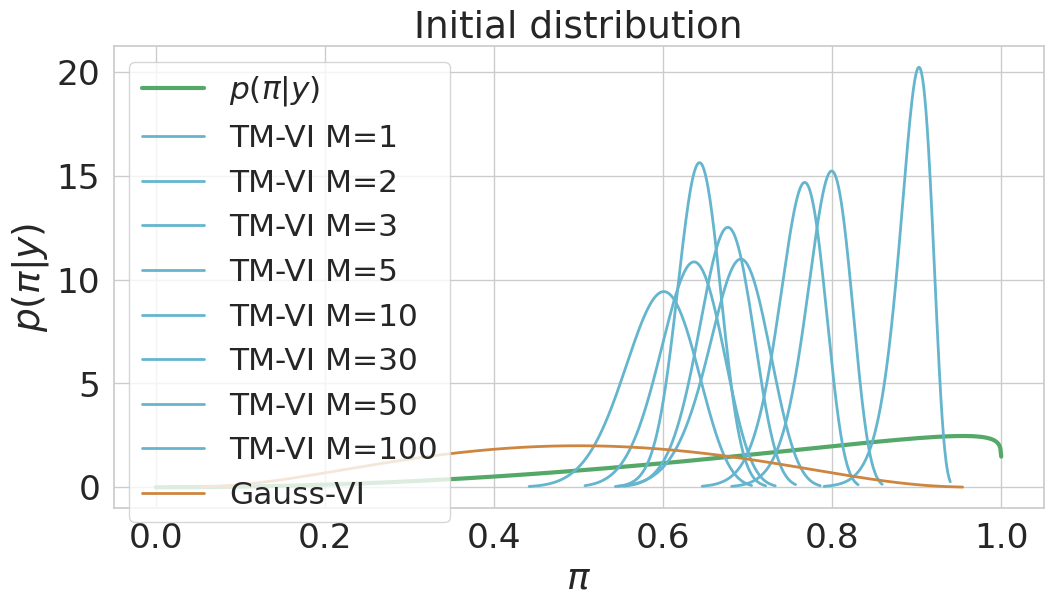

In [19]:
plt.figure(figsize=(12,6))
pdf_post = stats.beta(a=alpha_post, b=beta_post).pdf(x=pis)
sns.lineplot(data=pd.DataFrame.from_dict({'$p(\pi|y)$':pdf_post, '$\pi$':pis}), x='$\pi$', y='$p(\pi|y)$', label='$p(\pi|y)$', linewidth=3, color='g')
ls = 0
for name, model in models.items():
    layer = model.layers[0]
    w, log_qw = layer.sample(num=5000)
    w = w.numpy().squeeze()
    sort = np.argsort(w)
    w = w[sort]
    log_qw = log_qw.numpy().squeeze()[sort]
    #Transformation (in 0/1 restricted space)
    bij = tfp.bijectors.Sigmoid()
    pi = bij(w).numpy().squeeze()
    log_q_pi = log_qw - bij.forward_log_det_jacobian(w, event_ndims=0)
    q_pi = np.exp(log_q_pi)
    if "TM-VI" in name:
        plt.plot(pi, q_pi, label=name, linewidth=2., color='c')
        ls += 1
    else:
        plt.plot(pi, q_pi, label=name, linewidth=2., color='peru')
plt.legend(fontsize='small')
plt.title("Initial distribution")

### train

In [20]:
class LogKL(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['epochs'] = epoch
        # kl = [layer.losses[0] for layer in self.model.layers]
        # # logs['kl'] = tf.reduce_sum(kl)
        # logs['kl'] = kl

model_history = {}
for name, model in models.items():
    print(f"Start experiment with model {name}")
    #lr_callback = tf.keras.callbacks.LearningRateScheduler(partial(scheduler, lr_start=0.05, lr_stop=0.025, epochs=epochs))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss=sample_bernoulli_nll, run_eagerly=False)
    hist = model.fit(tf.ones((len(data),1)), ytensor, epochs=epochs, verbose=False, callbacks=[LogKL()])
    model_history[name] = hist.history

Start experiment with model TM-VI M=1


Start experiment with model TM-VI M=2


Start experiment with model TM-VI M=3


Start experiment with model TM-VI M=5


Start experiment with model TM-VI M=10


Start experiment with model TM-VI M=30


Start experiment with model TM-VI M=50


Start experiment with model TM-VI M=100


Start experiment with model Gauss-VI


In [21]:
import pandas as pd
print(pd.__version__)

1.5.3


In [22]:
### Save results of training in tidy format for ggplot epochs loss name
dfs = []
for name, hist in model_history.items():
    temp_df = pd.DataFrame(hist)
    temp_df['name'] = name
    dfs.append(temp_df)
df = pd.concat(dfs, ignore_index=True)
df.to_csv("bernoulli_1D_F1F2.csv")
df.head()

,loss,epochs,name
0,2.784064,0,TM-VI M=1
1,2.782912,1,TM-VI M=1
2,2.782259,2,TM-VI M=1
3,2.785938,3,TM-VI M=1
4,2.788852,4,TM-VI M=1


### Show posterior distribution of VIMLT and VI Gaussian and compute KL-Divergence
#### Table shows the KL-Divergence $D_{KL} (q_w(\pi) || p(\pi|D)$

TM-VI M=1
TM-VI M=2
TM-VI M=3
TM-VI M=5
TM-VI M=10
TM-VI M=30
TM-VI M=50
TM-VI M=100
Gauss-VI


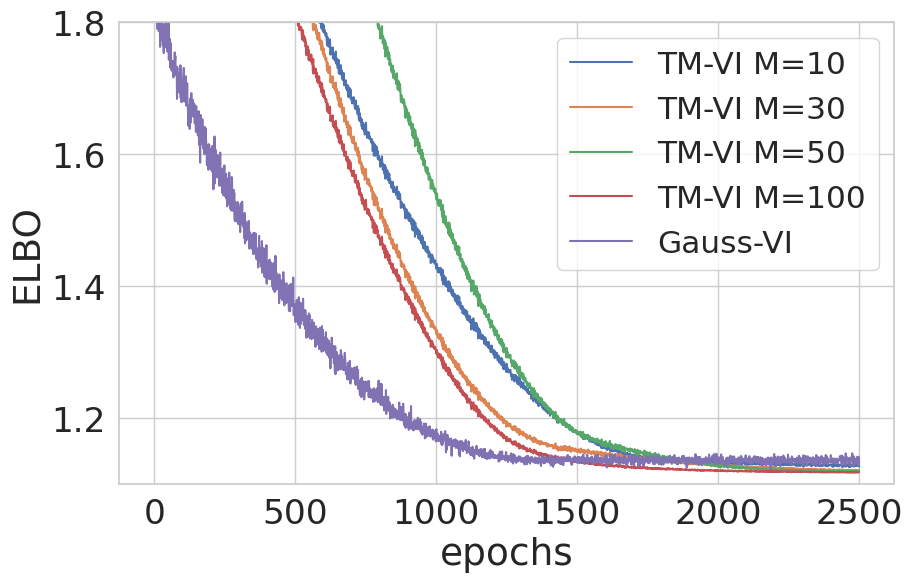

In [23]:
#for name, history in model_history.items():
#    print(name)
#    print(history.keys())
#    plt.figure()
#    plt.plot(history['epochs'], history['loss'])
#    plt.xlabel("epochs")
#    plt.ylabel("NLL")

plt.figure(figsize=(10, 6))
for name, history in model_history.items():
    print(name)
    if name == 'TM-VI M=10' or name == 'TM-VI M=30' or name == 'TM-VI M=50' or  name == 'TM-VI M=100' or name == 'Gauss-VI':
        plt.plot(history['epochs'], history['loss'], label=name)
plt.xlabel("epochs")
plt.ylabel("ELBO")
plt.ylim(1.1, 1.8)
plt.legend(fontsize='small')
plt.savefig("loss_bernoulli.pdf", bbox_inches='tight')
plt.show()


### Adding to results to data and saving  

The analytical solution.

In [24]:
post_analytic = tfd.Beta(alpha_post.astype(np.float32), beta_post.astype(np.float32))
df = pd.DataFrame({
     "pi" : pis,
     "p"  : post_analytic.prob(pis).numpy().squeeze(),
     "M"  : -1,
     "Method" : 'Analytical',
     "KL" : 0
  }
)
df

,pi,p,M,Method,KL
0,0.000100,1.476994e-08,-1,Analytical,0
1,0.001101,2.274699e-06,-1,Analytical,0
2,0.002102,8.843979e-06,-1,Analytical,0
3,0.003102,2.003615e-05,-1,Analytical,0
4,0.004103,3.603819e-05,-1,Analytical,0
...,...,...,...,...,...
995,0.995897,2.122977e+00,-1,Analytical,0
996,0.996898,2.068803e+00,-1,Analytical,0
997,0.997898,1.993973e+00,-1,Analytical,0
998,0.998899,1.873047e+00,-1,Analytical,0


In [25]:
if False:
  model = models.get('TM-VI M=30')
  layer = model.layers[0]
  w, log_qw = layer.sample(num=1000)
  w = w.numpy().squeeze()
  sort = np.argsort(w)
  w = w[sort]
  log_qw = log_qw.numpy().squeeze()[sort]
  bij = tfp.bijectors.Sigmoid()
  pi = bij(w).numpy().squeeze()
  log_q_pi = log_qw - bij.forward_log_det_jacobian(w, event_ndims=0)
  q_pi = np.exp(log_q_pi)
  plt.scatter(pi, q_pi)

VI Gaus with: N(<tf.Variable 'conjungate_dense_vi_gauss/kernel_mu:0' shape=(1, 1) dtype=float32, numpy=array([[1.3415164]], dtype=float32)>,[[1.2489936]])
Table shows the KL divergence KL(q(pi)||p(pi|D))


,KL
TM-VI M=1,0.223888
TM-VI M=2,0.047530
TM-VI M=3,0.022780
Gauss-VI,0.021907
TM-VI M=5,0.020309
TM-VI M=10,0.013996
TM-VI M=30,0.006581
TM-VI M=50,0.005153
TM-VI M=100,0.003686


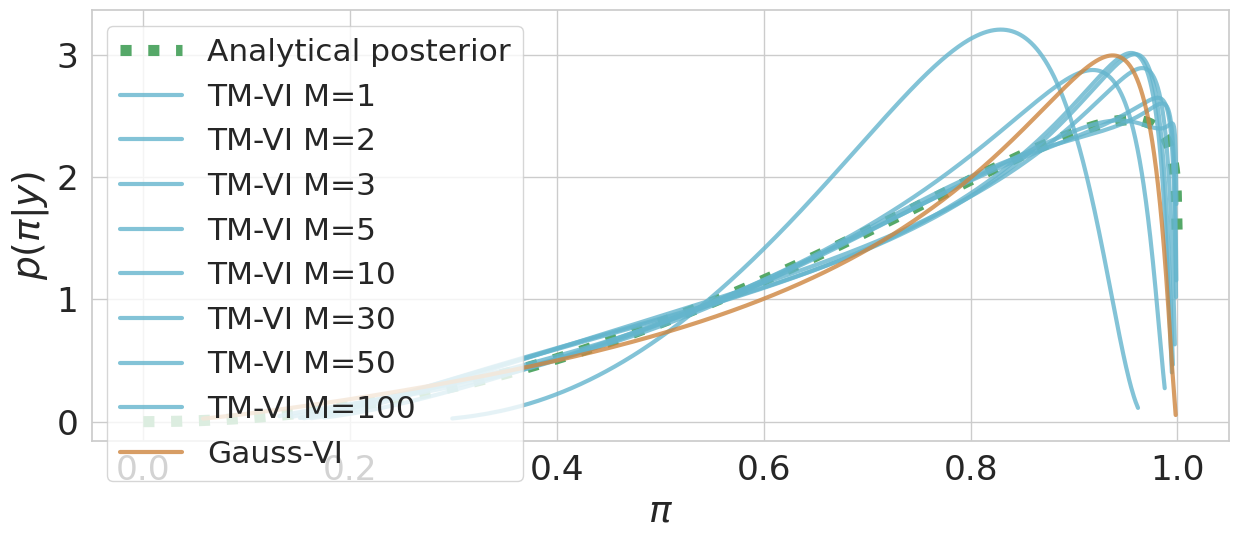

In [26]:
alpha_post = alpha + np.sum(data)
beta_post = beta + len(data) - np.sum(data)
plt.figure(figsize=(13,6))
sns.lineplot(data=pd.DataFrame.from_dict({'$p(\pi|y)$':post_analytic.prob(pis), '$\pi$':pis}), x='$\pi$', y='$p(\pi|y)$', label="Analytical posterior", linewidth=8, color='g', linestyle=(0, (1, 1.5)))

KLs = {}
linestyles = [(0, (2, 2)), (0, (1, 1)), '-.',  '--', '-']
ls = 0
i = 0
for name, model in models.items():
    layer = model.layers[0]
    w, log_qw = layer.sample(num=5000)
    w = w.numpy().squeeze()
    sort = np.argsort(w)
    w = w[sort]
    log_qw = log_qw.numpy().squeeze()[sort]
    #Transformation (in 0/1 restricted space)
    bij = tfp.bijectors.Sigmoid()
    pi = bij(w).numpy().squeeze()
    log_q_pi = log_qw - bij.forward_log_det_jacobian(w, event_ndims=0)
    q_pi = np.exp(log_q_pi)
    #Caluclation of the KL-Divergence
    log_p_pi_D = post_analytic.log_prob(pi)
    rel_entropy = q_pi * (log_q_pi - log_p_pi_D)
    kl_div = np.trapz(rel_entropy.numpy().reshape(-1), x=pi)
    kl_div
    KLs[name] = kl_div
    if "TM-VI" in name:
        plt.plot(pi, q_pi, label=name, linewidth=3., color='c', alpha=0.8)
        ls += 1
        M = Ms[i]
        i = i + 1
    else:
        plt.plot(pi, q_pi, label=name, linewidth=3., color='peru', alpha=0.8)
        M = 0.5

    df = pd.concat([df, pd.DataFrame({
      "pi" : pi,
      "p"  : q_pi.squeeze(),
      "M"  : M,
      "Method" : name,
      "KL" : kl_div
      }
    )
    ])



plt.legend(fontsize='small')
# plt.title("Posterior distribution")
plt.tight_layout()
plt.savefig("00_conj_posterior.pdf")

print("Table shows the KL divergence KL(q(pi)||p(pi|D))")
pd.DataFrame.from_dict(KLs, orient='index', columns=["KL"]).sort_values('KL', ascending=False)


In [27]:
df

,pi,p,M,Method,KL
0,0.000100,1.476994e-08,-1.0,Analytical,0.000000
1,0.001101,2.274699e-06,-1.0,Analytical,0.000000
2,0.002102,8.843979e-06,-1.0,Analytical,0.000000
3,0.003102,2.003615e-05,-1.0,Analytical,0.000000
4,0.004103,3.603819e-05,-1.0,Analytical,0.000000
...,...,...,...,...,...
4995,0.993920,5.757558e-01,0.5,Gauss-VI,0.021907
4996,0.994162,5.431081e-01,0.5,Gauss-VI,0.021907
4997,0.994909,4.423800e-01,0.5,Gauss-VI,0.021907
4998,0.998021,7.789236e-02,0.5,Gauss-VI,0.021907


In [28]:
df.to_csv('bernoulli_1D_F1F2.csv.gz', index=False)